# Acquiring Data with Pycro-Manager

This tutorial demonstrates how to use the `Acquisition` class in Pycro-Manager to acquire data, as well as several powerful features that the class provides. As the areas highlighted in red in the figures below demonstrate, we'll be using several features of Micro-Manager including the C++ Core and Java codebase for image display, data saving, and acquisition. However, most of that will be going on behind the scenes, so you'll only be dealing with Python 

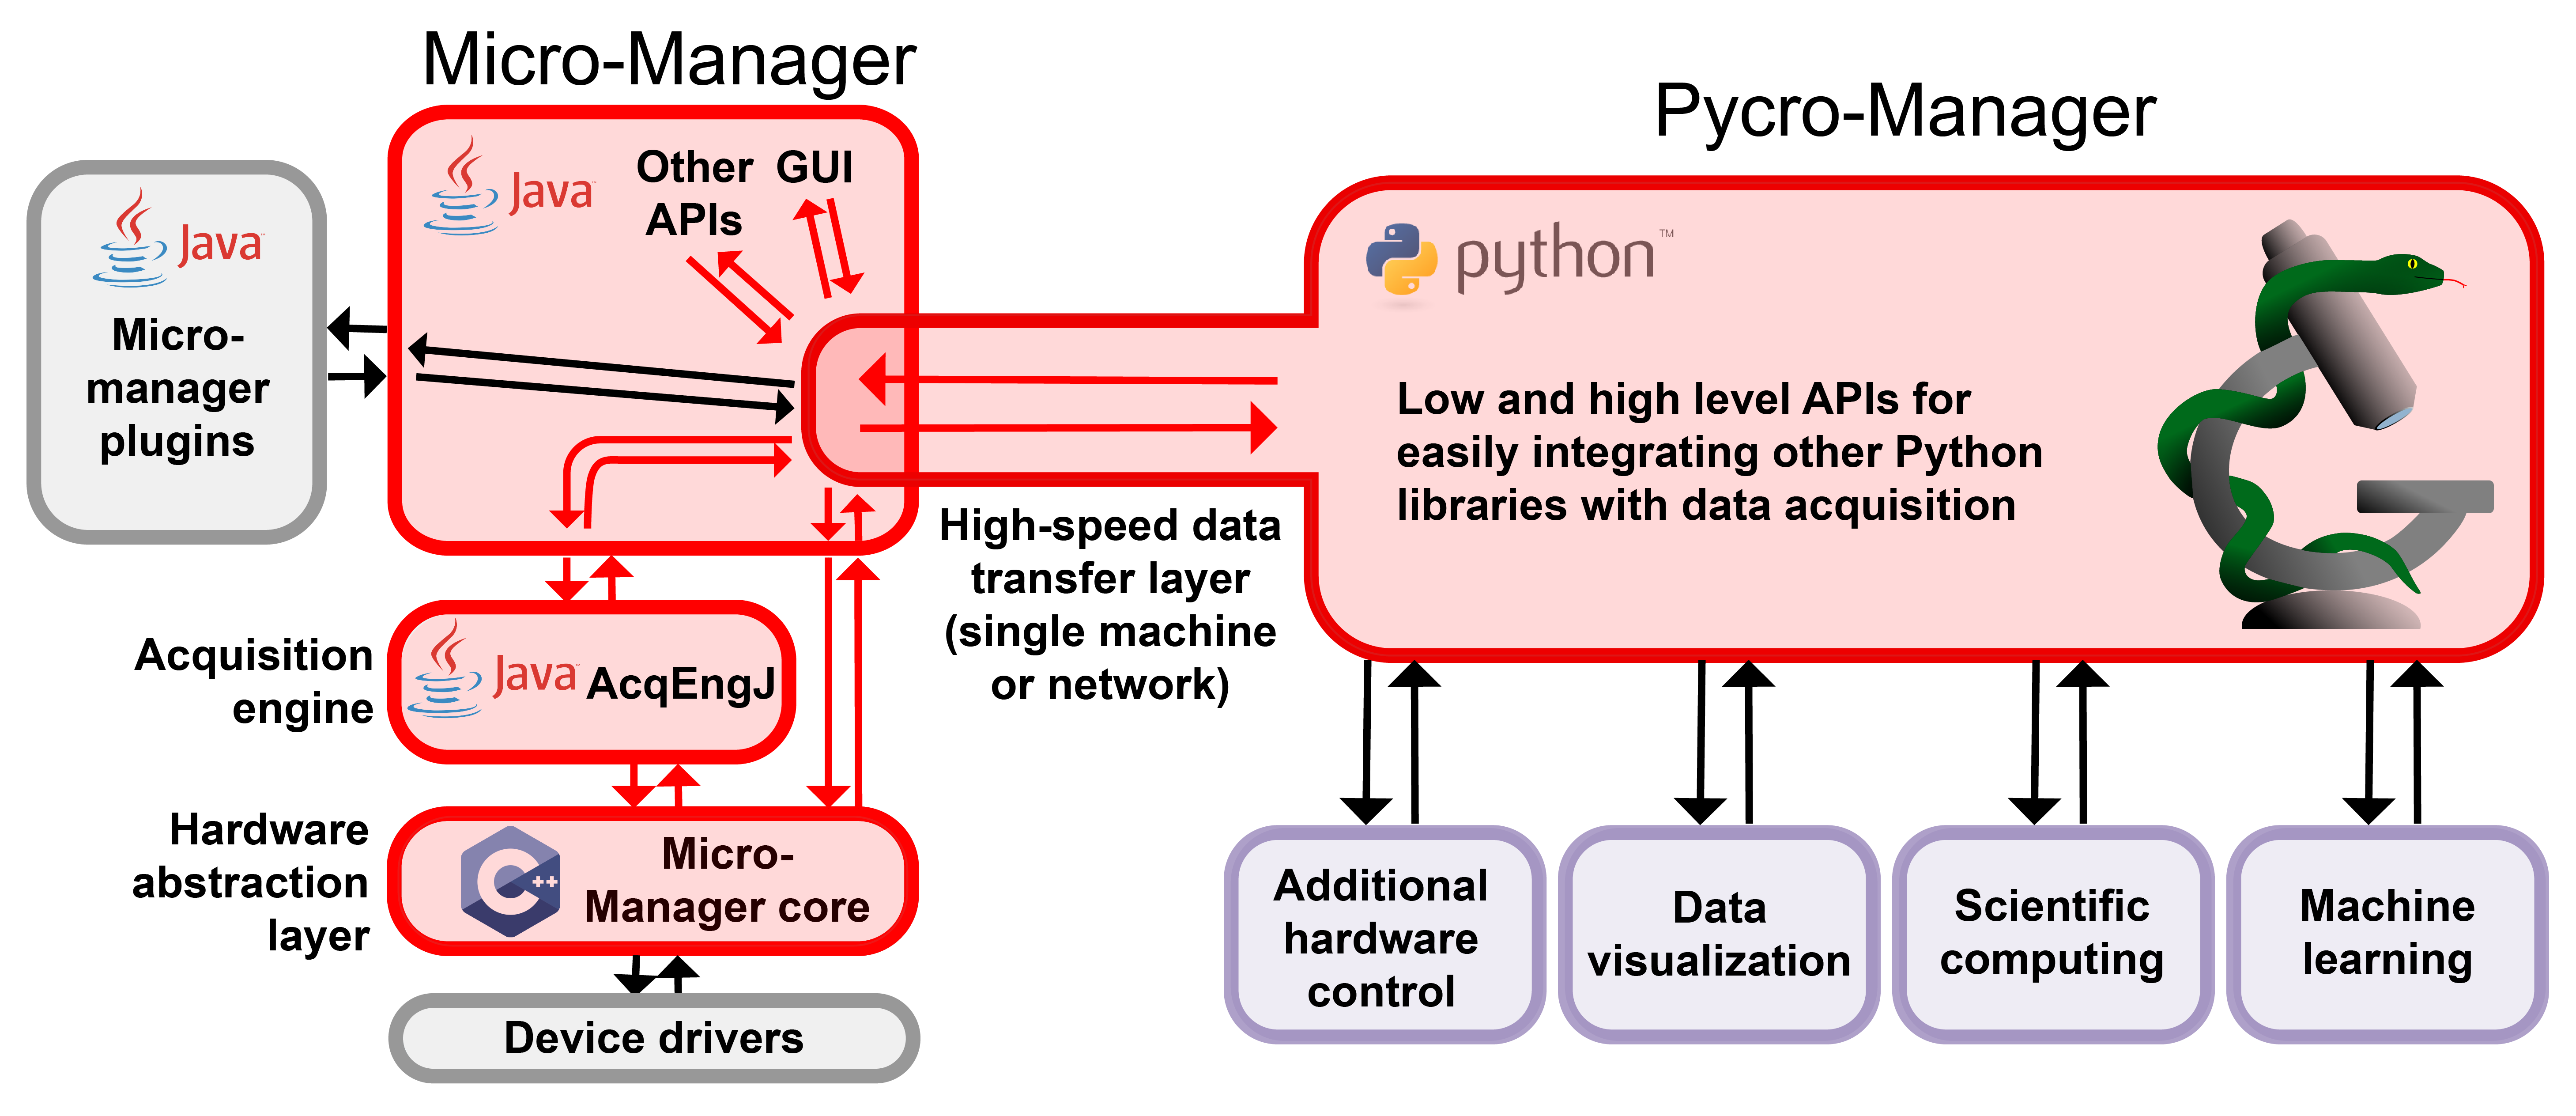

## Setup

0) This tutorial is written for Windows or OSX and assumes you already have a working installation of Python version 3.6 or greater

1) Download and install the latest nighlty build of Micro-Manager 2.0gamma [here](https://micro-manager.org/wiki/Micro-Manager_Nightly_Builds).

2) Open Micro-Manager, select tools-options, and check the box that says Run server on port 4827 (you only need to do this once)

3) Run the code below to install pycromanager

In [ ]:
!pip install pycromanager --upgrade

### Define data saving location
The cells below will run acquisitions that will save data to disk. As a convenience, we will define a common data saving location and name here

In [2]:
# TODO: change these if you're not Henry Pinkard 

# Note: on Windows platforms you sometimes need an r before string names
# see here https://stackoverflow.com/questions/33729045/what-does-an-r-represent-before-a-string-in-python
save_dir = r'/Users/henrypinkard/tmp'
save_name = r'Acquisition_test'

## Basic acquisition and image viewer

To begin, we'll start with an extremely simple acquistion: just collecting 10 images in a row. To do this we'll use the Pycro-Manager `Acqusition` class, along the the `multi_d_acquisition_events` function, which defines what to acquire (more on this later...)

In [2]:
from pycromanager import Acquisition, multi_d_acquisition_events

with Acquisition(directory=save_dir, name=save_name) as acq:
    events = multi_d_acquisition_events(num_time_points=10)
    acq.acquire(events)

Running this will pop up an image viewer showing the data just collected. Take some time to familiarize yourself with this viewer:
 - The scrollbar below the image allows you to cycle through the 10 images that were just collected 
 - The green arrow on the bottom left lets you animate playback
 - On the controls on the right side, you can change image contrast by dragging the black and white sliders across the image hisotgram
 - Clicking the "metadata" near the top right lets you view Summary Metadata (one copy of this for the whole acquisiton) and Image Metadata (one copy for each image)

Now we can do something a little more complicated: an multi-channel, Z-stack acquisition:

In [3]:
with Acquisition(directory=save_dir, name=save_name) as acq:
    events = multi_d_acquisition_events(
                        channel_group='Channel', channels=['DAPI', 'FITC'], # These correspond to a Config Group 
                        z_start=0, z_end=6, z_step=0.4,
                        order='cz')
    acq.acquire(events)

There are now two histograms on the image viewer (one for each channel). Using the checkboxes next to each one we can view them together or one at a time

### Exercise
Using `multi_d_acquisition_events`, run a timelapse acquisition with 2 min spacing between successive time points, that collects a Z-stack starting at 0 µm and and ending at 10 µm with 1 µm spacing between images. 

The documentation for `multi_d_acquisition_events` can be found [here](https://pycro-manager.readthedocs.io/en/latest/apis.html#pycromanager.multi_d_acquisition_events) in the Pycro-Manager documentation.

In [ ]:
### Your code here ###

### Customized acquisistions

`multi_d_acquisition_events` covers a lot of use cases, but supposed we wanted to acquire something that doesn't quite fit into the channels/Z-stack/timelapse paradigm. The `Acquisition` class allows for this, but to understand how, we need to dig more into what `multi_d_acquisition_events` is actually doing. By printing out `events` we can see:

In [4]:
events = multi_d_acquisition_events(num_time_points=5)
print(events)

[{'axes': {'time': 0}}, {'axes': {'time': 1}}, {'axes': {'time': 2}}, {'axes': {'time': 3}}, {'axes': {'time': 4}}]


`events` is a `list`, and each entry is a `dict`. `multi_d_acquisition_events` is just a convenience function for generating this data structure, which describes the acquistiion. Printing each event on its own row makes things more clear:

In [5]:
for e in events:
    print(e)

{'axes': {'time': 0}}
{'axes': {'time': 1}}
{'axes': {'time': 2}}
{'axes': {'time': 3}}
{'axes': {'time': 4}}


We see that it has a key `axes`, which maps to another `dict` that contains the unique integer coordiante along the `time` axis. Compare this to the events for adding in a Z-stack:

In [6]:
events = multi_d_acquisition_events(num_time_points=4, z_start=50.2, z_end=56.2, z_step=2)
for e in events:
    print(e)

{'axes': {'time': 0, 'z': 0}, 'z': 50.2}
{'axes': {'time': 0, 'z': 1}, 'z': 52.2}
{'axes': {'time': 0, 'z': 2}, 'z': 54.2}
{'axes': {'time': 0, 'z': 3}, 'z': 56.2}
{'axes': {'time': 1, 'z': 0}, 'z': 50.2}
{'axes': {'time': 1, 'z': 1}, 'z': 52.2}
{'axes': {'time': 1, 'z': 2}, 'z': 54.2}
{'axes': {'time': 1, 'z': 3}, 'z': 56.2}
{'axes': {'time': 2, 'z': 0}, 'z': 50.2}
{'axes': {'time': 2, 'z': 1}, 'z': 52.2}
{'axes': {'time': 2, 'z': 2}, 'z': 54.2}
{'axes': {'time': 2, 'z': 3}, 'z': 56.2}
{'axes': {'time': 3, 'z': 0}, 'z': 50.2}
{'axes': {'time': 3, 'z': 1}, 'z': 52.2}
{'axes': {'time': 3, 'z': 2}, 'z': 54.2}
{'axes': {'time': 3, 'z': 3}, 'z': 56.2}


Now there is a new axis in `axes`, `z`, which gives the integer coordinate along the new axis. There is also a `z` outside of `axes`, which is givng the coordinate in µm of the focus drive.

We don't have to use `multi_d_acquisition_events`, and in fact we can create events from scratch as long as they conform to the [acquistion event specification](https://pycro-manager.readthedocs.io/en/latest/apis.html#acquisition-event-specification)

### Exercise: 
Run a custom acquisition, creating the events yourself, which runs a 5 image timelapse, that takes three images at each time step, using a new axis name of your choosing

In [5]:
### Your code here ###

## Acquisition hooks
Often customized experiments require running additonal hardware synchronosly with the acuistion process or making adjustments on the fly. For example, control of microfluidics during an experiment, automatically refocusing, turning on and off other hardware, etc. These tasks can accomlished using **Acquistion hooks** which allow you to execute abutrary Python code at various points in the acquisiton cycle. This concept is shown in the green portion of the figure below

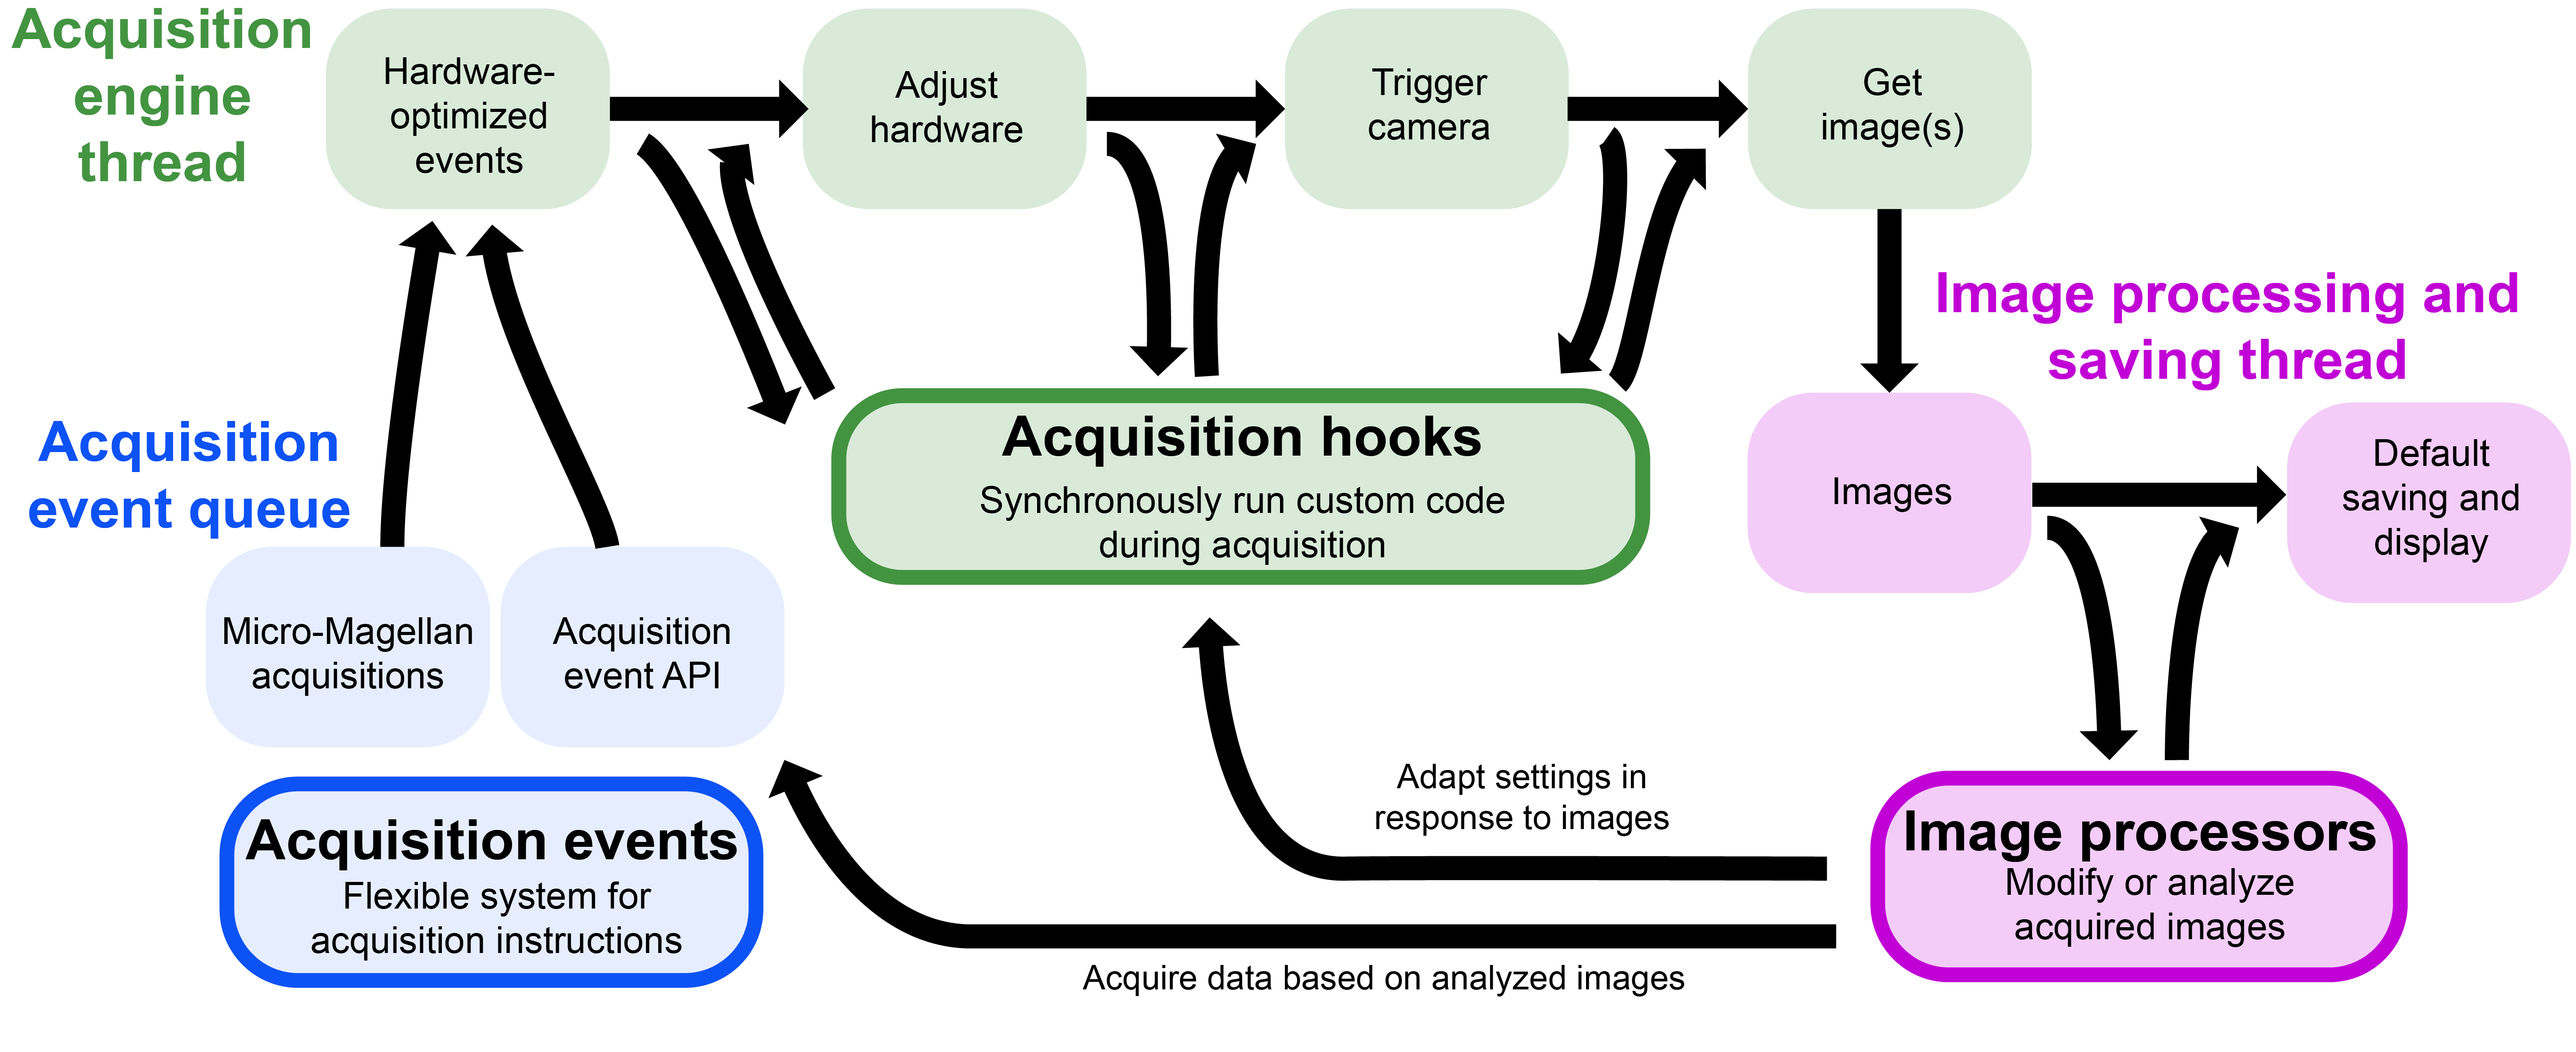

<br/><br/><br/>

A basic acquistion hook is implemented by defining a Python function, then passing that function in when creating the acquisition:

In [3]:
def hook_fn(event):
    ### Do something here ###
    return event

with Acquisition(directory=save_dir, name=save_name, pre_hardware_hook_fn=hook_fn) as acq:
        events = multi_d_acquisition_events(num_time_points=4)
        acq.acquire(events)

The `event` in passed in as an argument is the same acquisition event defined in the previous section

### Exercise

Run an acquisition that collects ten time points with a 5 second interval in between. Use an acquisition hook to figure out which time point is running and print a message to track the acquisitions progress

## Image processors
Many experiments benefit from access to image data as it is being acquired, enabling it to be modified, diverted to customized visualization and saving, or analyzed on-the-fly to control acquisition. Image processors can be used for this purpose.

The simplest image processor function takes two arguments: the pixel data (a 2D numpy array) and metadata (a python dictionary) of the current image.

In [10]:
def img_process_fn(image, metadata):
    ### Do something here ###
    return image, metadata

with Acquisition(directory=save_dir, name=save_name, image_process_fn=img_process_fn) as acq:
        events = multi_d_acquisition_events(num_time_points=5)
        acq.acquire(events)

In `img_process_fn`, `image` is a 2D numpy array of pixels, and `metadata` is a `dict` that maps string keys to metadata values

### Exercise

Run an acquisition with an image processor that rotates every image 90 degrees (hint: the numpy function `rot90` can helo with this)

In [ ]:
### Your code here ###

### Finding the image axes
If you're not applying the same operation to every image, it's essential to figure out which image is which. This can be done using the `'Axes'` key in the metadata, which recovers the Axes `dict` that was supplied with the acquisition event that generated this image. The channel axis is treated specially -- it won't appear in here, but the channel name can be gotten by getting the value of the `'Channel'` key in the metadata

In [8]:
def img_process_fn(image, metadata):
    # get the axes dictionary used to generate this image
    axes = metadata['Axes']
    channel_name = metadata['Channel']
    ### Do something here ###
    return image, metadata

### Exercise

Run a two-channel acquisition with an image processor that rotates every image in one channel by 90 degrees, while leaving the other channel unchanged

In [ ]:
### Your code here ###

## Opening data with napari
For analyzing data with Python, visualizing the data in a Python-based viewer can be very useful. [Napari](https://napari.org/) provides a useful multi-dimensional viewer for this. The following block shows how to run an `Acquisition` with Pycro-Manager, open the dataset that was just acquired, and open a Napari viewer.

**Note**: this requires having installed napari. Visit the [Napari documentation](https://napari.org/) for up-to-date instructions on doing this

In [10]:
from pycromanager import Dataset, Acquisition, multi_d_acquisition_events
import napari

with Acquisition(directory=save_dir, name=save_name) as acq:
    events = multi_d_acquisition_events(
                        channel_group='Channel', channels=['DAPI', 'FITC'], # These correspond to a Config Group 
                        z_start=0, z_end=6, z_step=0.4,
                        order='cz')
    acq.acquire(events)

# read the data that was just acquired
dataset = Dataset(acq.get_disk_location())

# dask is a library for piecing together smaller numpy arrays for scalable analysis...but for 
# our purposes its just a convenient data container here that enables working with data 
# without loading it all into memory at once
dask_array = dataset.as_array()

# visualize data using napari
with napari.gui_qt():
    v = napari.Viewer()
    v.add_image(dask_array)